In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [ ]:
class GDA:
  def __init__(self):
    self.phi = None
    self.mu = None
    self.sigma = None
    self.classes = None

  def fit(self, x, y, classes = 2):
    self.classes = classes
    m, f = x.shape
    phi = np.mean(y)
    mu = []
    for i in range(self.classes):
      mu.append(np.mean(x[y == i], axis=0))

    sigma = np.zeros([f, f])
    for i in range(m):
      v = (x[i] - mu[y[i]]).reshape(-1, 1)
      sigma += v @ (v).transpose()
    sigma /= m
    self.phi, self.mu, self.sigma = phi, mu, sigma

  def predict(self, x_matrix):
    sigma_inv = np.linalg.inv(self.sigma)
    predictions = []
    for x in x_matrix:
        min_measure = None
        min_arg = None
        for i in range(self.classes):
            v = (x - self.mu[i]).reshape(-1, 1)
            measure = ((v).transpose() @ sigma_inv @ v).item()
            # Use only needed measure from p(x|y=i)
            if min_measure is None or min_measure > measure:
                min_measure = measure
                min_arg = i
        predictions.append(min_arg)
    return np.array(predictions)

  def predict_probabilities(self, x):
    sigma_det = np.linalg.det(self.sigma)
    sigma_inv = np.linalg.inv(self.sigma)
    probs = []
    f = x.shape[0]
    for i in range(self.classes):
      v = (x - self.mu[i]).reshape(-1, 1)
      probs.append(1.0 / (np.power(2 * np.pi, f / 2) * np.sqrt(sigma_det)) * np.exp(-0.5 * ((v).transpose() @ sigma_inv @ v).item()) * self.phi)
    probs /= sum(probs)
    return probs

In [ ]:
# Generate a 2D linearly separable dataset
x, y = make_classification(n_samples=15, n_features=2, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1, class_sep=2.0, random_state=42)

In [ ]:
GDA_model = GDA()
GDA_model.fit(x, y)

In [ ]:
def plot_covariance_ellipses(mean, cov, ax, **kwargs):
    # Compute eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Compute the angle of the ellipse in degrees
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    for n_std in range(1, 4):  # Plot 1σ, 2σ, and 3σ ellipses
        # Width and height of the ellipse are proportional to the square roots of eigenvalues
        width, height = 2 * n_std * np.sqrt(eigenvalues)

        # Create an ellipse patch
        ellipse = Ellipse(mean, width, height, angle, edgecolor=kwargs.get('edgecolor', 'black'),
                          facecolor='none', lw=kwargs.get('lw', 2), linestyle=kwargs.get('linestyle', '-'))

        # Add the ellipse to the plot
        ax.add_patch(ellipse)

<ipython-input-189-214716c36b04>:13: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, angle, edgecolor=kwargs.get('edgecolor', 'black'),


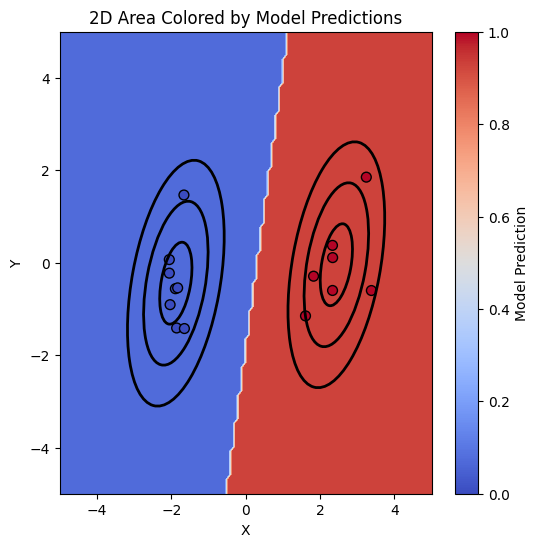

In [ ]:
def model_predict(x, y):
    arr = np.array([x, y])
    return GDA_model.predict(arr.reshape(2,-1).T)

# Define the range of the 2D plot
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)

# Create a meshgrid for the x and y coordinates
X, Y = np.meshgrid(x_range, y_range)

# Get predictions for each (x, y) pair
Z = model_predict(X, Y).reshape(100,100)

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))
plt.contourf(X, Y, Z, cmap='coolwarm')
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm', s=50, edgecolor='k')
plt.colorbar(label='Model Prediction')

# Now, assuming GDA_model has means_ and covariances_ attributes for each class
for mean in GDA_model.mu:
    # Plot the covariance ellipse for each Gaussian
    plot_covariance_ellipses(mean, GDA_model.sigma, ax, edgecolor='black', facecolor='none', lw=2)

plt.title('2D Area Colored by Model Predictions')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()